In [12]:
import torch
import random
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import huffman
import math
import faiss
import sys
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(1, '../core')
from patchutils import symdnn_purify, fm_to_symbolic_fm as sym_mnist

# MNIST Experiments: Size reduction through Huffman coding


In [5]:
def plot_pdf_distribution(pdf):
    print(len(pdf))
    plt.rcParams['figure.figsize'] = [4,3]
    plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
    plt.rcParams.update({'font.size': 10})
    # plt.ticklabel_format(axis='x', style="sci", scilimits=(0,0), useOffset=False)
    # plt.hist(imagenet_pdf2048, bins=25, alpha=0.75, rwidth=0.75)
    # plt.gca().set(ylabel='# of centroids in that bin', xlabel='# of centroids in a bin is hit', xscale='log', autoscale_on=True);
    plt.ticklabel_format(style='plain')
    plt.hist(pdf, bins=25, alpha=0.75, rwidth=0.75) #, log=True)
    plt.gca().set(ylabel='# of centroids in that bin', xlabel='# of times centroids in a bin is hit');

In [6]:
def plot_data_savings(pdf,n_clusters):
    # create the dictionary
    freq_dict = []
    for i in range(n_clusters):
        freq_dict.append((i, pdf[i]))
    code_book = huffman.codebook(freq_dict)   

    code_book_dist = np.zeros((n_clusters,),dtype=np.int)
    for j in range(n_clusters):
        code_book_dist[j]=len(code_book[j])

    plt.rcParams['figure.figsize'] = [3,3]
    plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
    plt.rcParams.update({'font.size': 10})
    plt.ticklabel_format(style='plain')
    plt.hist(code_book_dist, bins=6, alpha=0.75, rwidth=0.75)
    plt.gca().set(ylabel='# of symbols in that bin', xlabel='bins of bits per symbol');    

    base_bits = (math.log10(n_clusters) / math.log10(2))
    print(base_bits)

    # with no encoding, 11 bits needed to encode 2048 symbols
    total_non_encoded = 0
    for i in range(n_clusters):
        total_non_encoded += pdf[i]*base_bits

    total_encoded = 0
    for i in range(n_clusters):
        total_encoded += pdf[i]*code_book_dist[i]
    return 100*(1 - total_encoded/total_non_encoded)

In [7]:
# Basic definitions for MNIST inference

#  From my training code
random_seed = 1 


torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
apply_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(),
                                      transforms.Normalize((0.1309,), (0.2893,))])
# Change the dataset folder to the proper location in a new system
testset = datasets.MNIST(root='../../../dataset', train=False, download=True, transform=apply_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
testloader2 = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

class CNN_LeNet(nn.Module):
    def __init__(self):
        super(CNN_LeNet, self).__init__()
        # Define the net structure
        # This is the input layer first Convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10) 
    
    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x,dim=1)
        return x
pretrained_model = "./mnist_v0.pt"
mnist_model = CNN_LeNet() 
mnist_model.load_state_dict(torch.load(pretrained_model))
num_class = 10
mnist_model.eval()

CNN_LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
# Lets check the kind of prediction the model is doing - the standard non symbolic infrence
def mnist_test_base_acc(model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for testdata in testloader:
            X, y = testdata
            output = model.forward(X)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            # If the initial prediction is wrong, dont bother attacking, just move on
            if init_pred.item() == y.item():
                #print("correct")
                correct += 1
            total += 1    
    return 100*round(correct/total, 4)

In [11]:
# Test accuracy of symbolic inference
def mnist_test_sym_acc(model,sym_mnist,n_clusters, index,  patch_size, stride, channel_count, instr=False):
    correct = 0 
    total = 0 
    centroid_lut = index.reconstruct_n(0, n_clusters)
    if instr:
        pdf = np.zeros((n_clusters,), dtype=int)
    model.eval()
    with torch.no_grad():
        for data in testloader:
            X, y = data
            if instr:
                Xsym_, pdf = sym_mnist(X.squeeze(), n_clusters, index, centroid_lut,  patch_size, stride, channel_count, ana=False, multi=False, instr=True, randomize=False, rlevel=None, rbalance=True, pdf=pdf)
            else:
                Xsym_ = sym_mnist(X.squeeze(), n_clusters, index, centroid_lut, patch_size, stride, channel_count, ana=False, multi=False, instr=False, randomize=False, rlevel=None, rbalance=True, pdf=None)
            Xsym = torch.from_numpy(Xsym_)
            Xsym = Xsym.unsqueeze(0)
            output = model.forward(Xsym.float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
    if instr:
        return round(correct/total, 4), pdf
    else:
        return round(correct/total, 4)

In [13]:
# Standard non symbolic inference
acc = mnist_test_base_acc(mnist_model)
print("Non Symbolic test accuracy:{}% ".format(acc))

Non Symbolic test accuracy:99.03% 


In [13]:
# Load the different codebooks & perform symbolic inference
# Start with 512
index = faiss.read_index("./kmeans_img_mnist_k2_s0_c512_v0.index")
n_clusters=512
patch_size = (2, 2)
channel_count = 1
repeat = 2
location=False
stride = 0
acc = mnist_test_sym_acc(mnist_model, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 512):{}% ".format(100*acc))

Symbolic test accuracy (codebook 512):99.02% 


Symbolic test accuracy (codebook 512):99.02% 
512
9.0
Savings in storage for MNIST (10k) testset (codebook: 512 symbols): 58.10%


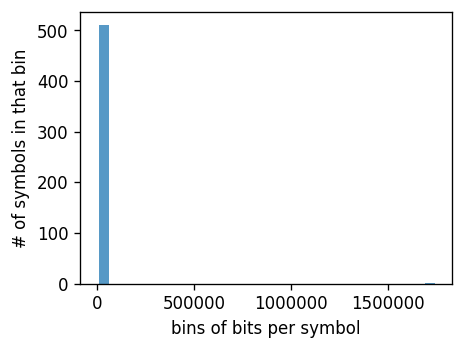

In [15]:
#Lets Check data savings with huffman encoding of the symbols using 512 symbol codebook
index = faiss.read_index("./kmeans_img_mnist_k2_s0_c512_v0.index")
n_clusters=512
acc, pdf = mnist_test_sym_acc(mnist_model, sym_mnist, n_clusters, index,  patch_size, stride, channel_count, instr=True)
print("Symbolic test accuracy (codebook 512):{}% ".format(100*acc))
plot_pdf_distribution(pdf)
savings = plot_data_savings(pdf,n_clusters)
print("Savings in storage for MNIST (10k) testset (codebook: 512 symbols): {:.2f}%".format(savings))    

In [18]:
# Now with 256
index = faiss.read_index("./kmeans_img_mnist_k2_s0_c256_v0.index")
n_clusters=256
acc = mnist_test_sym_acc(mnist_model, sym_mnist , n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 256):{}% ".format(100*acc))

Symbolic test accuracy (codebook 256):99.1% 


In [20]:
# Now with 128
index = faiss.read_index("./kmeans_img_mnist_k2_s0_c128_v0.index")
n_clusters=128
acc = mnist_test_sym_acc(mnist_model, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 128):{}% ".format(100*acc))

Symbolic test accuracy (codebook 128):99.06% 


Symbolic test accuracy (codebook 128):99.06% 
128
7.0
Savings in storage for MNIST (10k) testset (codebook: 128 symbols): 56.47%


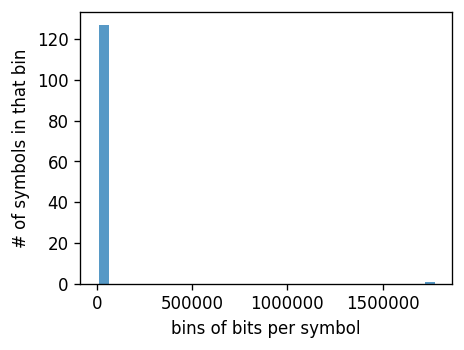

In [8]:
#Lets Check data savings with huffman encoding of the symbols using 128 symbol codebook
from  patchutils_mnist import  fm_to_symbolic_fm_instr as sym_mnist_instr
index = faiss.read_index("./kmeans_img_mnist_k2_s0_c128_v0.index")
n_clusters=128
acc, pdf = mnist_test_sym_acc(mnist_model, sym_mnist_instr , n_clusters, index,  patch_size, stride, channel_count, instr=True)
print("Symbolic test accuracy (codebook 128):{}% ".format(100*acc))
plot_pdf_distribution(pdf)
savings = plot_data_savings(pdf,n_clusters)
print("Savings in storage for MNIST (10k) testset (codebook: 128 symbols): {:.2f}%".format(savings))    

In [17]:
# Now with 64
index = faiss.read_index("./mnist/kmeans_img_mnist_k2_s0_c64_v0.index")
n_clusters=64
acc = mnist_test_sym_acc(mnist_model, sym_mnist , n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 64):{}% ".format(100*acc))

Symbolic test accuracy (codebook 64):99.02% 


Symbolic test accuracy (codebook 64):99.02% 
64
6.0
Savings in storage for MNIST (10k) testset (codebook: 64 symbols): 56.10%


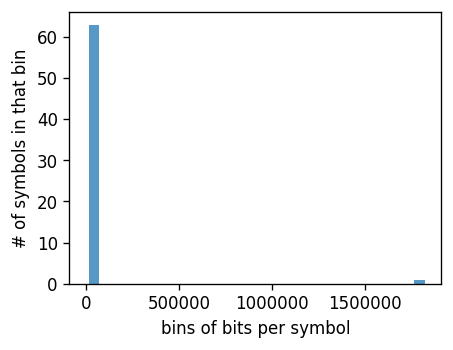

In [22]:
#Lets Check data savings with huffman encoding of the symbols using 64 symbol codebook
from  patchutils_mnist import  fm_to_symbolic_fm_instr as sym_mnist_instr
index = faiss.read_index("./kmeans_img_mnist_k2_s0_c64_v0.index")
n_clusters=64
acc, pdf = mnist_test_sym_acc(mnist_model, sym_mnist_instr , n_clusters, index,  patch_size, stride, channel_count, instr=True)
print("Symbolic test accuracy (codebook 64):{}% ".format(100*acc))
plot_pdf_distribution(pdf)
savings = plot_data_savings(pdf,n_clusters)
print("Savings in storage for MNIST (10k) testset (codebook: 64 symbols): {:.2f}%".format(savings))    

In [12]:
# Now with 32
index = faiss.read_index("./mnist/kmeans_img_mnist_k2_s0_c32_v0.index")
n_clusters=32
acc = mnist_test_sym_acc(mnist_model, sym_mnist , n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 32):{}% ".format(100*acc))

Symbolic test accuracy (codebook 32):99.1% 


Symbolic test accuracy (codebook 32):99.1% 
32
5.0
Savings in storage for MNIST (10k) testset: 55.00%


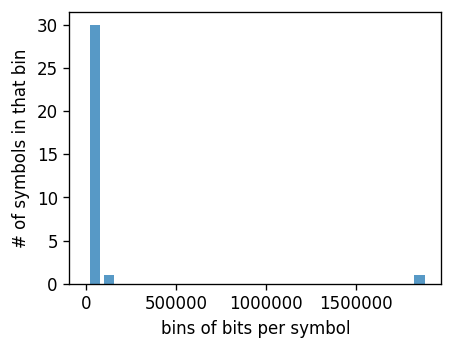

In [16]:
#Lets Check data savings with huffman encoding of the symbols using 32 symbol codebook
from  patchutils_mnist import  fm_to_symbolic_fm_instr as sym_mnist_instr
index = faiss.read_index("./mnist/kmeans_img_mnist_k2_s0_c32_v0.index")
n_clusters=32
acc, pdf = mnist_test_sym_acc(mnist_model, sym_mnist_instr , n_clusters, index,  patch_size, stride, channel_count, instr=True)
print("Symbolic test accuracy (codebook 32):{}% ".format(100*acc))
plot_pdf_distribution(pdf)
savings = plot_data_savings(pdf,n_clusters)
print("Savings in storage for MNIST (10k) testset (codebook: 32 symbols): {:.2f}%".format(savings))    

Symbolic test accuracy (codebook 32):99.1% 
256
8.0
Savings in storage for MNIST (10k) testset (codebook: 256 symbols): 56.95%


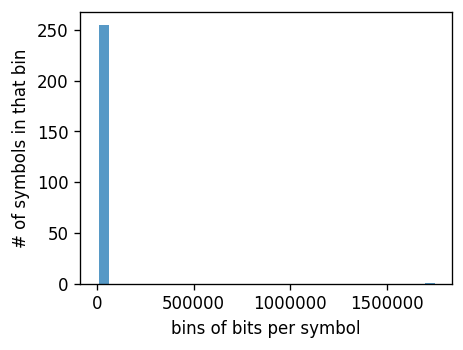

In [17]:
#Lets Check data savings with huffman encoding of the symbols using 256 symbol codebook
from  patchutils_mnist import  fm_to_symbolic_fm_instr as sym_mnist_instr
index = faiss.read_index("./mnist/kmeans_img_mnist_k2_s0_c256_v0.index")
n_clusters=256
acc, pdf = mnist_test_sym_acc(mnist_model, sym_mnist_instr , n_clusters, index,  patch_size, stride, channel_count, instr=True)
print("Symbolic test accuracy (codebook 32):{}% ".format(100*acc))
plot_pdf_distribution(pdf)
savings = plot_data_savings(pdf,n_clusters)
print("Savings in storage for MNIST (10k) testset (codebook: 256 symbols): {:.2f}%".format(savings))    